# Домашка 2

### Задание 1

### Надеюсь можно использовать numpy массивы для хранения element чтобы не реализовывать матричные операции)

In [82]:
import torch
import numpy as np

### Дореализовали все базовые операции. Теперь можем складывать / вычитать / делить / умножать элементы с другими элементами или со скалярами в любом порядке и возводить элемент в числовую степень и число в степень элемента

In [2]:
class Element:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Element(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        if isinstance(other, Element):
            res = Element(self.data + other.data, (self, other), '+')
            def _backward():
                self.grad += 1 * res.grad
                other.grad += 1 * res.grad
            res._backward = _backward
            return res
        else:
            res = Element(self.data + other, tuple([self]), '+')
            def _backward():
                self.grad += 1 * res.grad
            res._backward = _backward
            return res
        
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + other * (-1)
    
    def __rsub__(self, other):
        return other + (-1) * self
    
    def __neg__(self):
        return 0 - self

    def __mul__(self, other):
        if isinstance(other, Element):
            res = Element(self.data * other.data, (self, other), '*')
            def _backward():
                self.grad += other.data * res.grad
                other.grad += self.data * res.grad
            res._backward = _backward
            return res
        else:
            res = Element(self.data * other, tuple([self]), '*')
            def _backward():
                self.grad += other * res.grad
            res._backward = _backward
            return res
        
    def __rmul__(self, other):
        return self * other
        
    def __truediv__(self, other):
        if isinstance(other, Element):
            res = Element(self.data / other.data, (self, other), '/')
            def _backward():
                self.grad += 1 / other.data * res.grad
                other.grad += (-1) * self.data / other.data ** 2 * res.grad
            res._backward = _backward
            return res
        else:
            res = Element(self.data / other, tuple([self]), '/')
            def _backward():
                self.grad += 1 / other * res.grad
            res._backward = _backward
            return res
        
    def __rtruediv__(self, other):
        res = Element(other / self.data, tuple([self]), '/')
        def _backward():
            self.grad += (-1) * other/ self.data ** 2 * res.grad
        res._backward = _backward
        return res            
    
    def __pow__(self, power):
        res = Element(self.data ** power, tuple([self]), '**')
        def _backward():
            self.grad += power * self.data ** (power - 1) * res.grad
        res._backward = _backward
        return res
    
    def __rpow__(self, other):
        res = Element(other ** self.data, tuple([self]), '**')
        def _backward():
            self.grad += other ** self.data * np.log(other) * res.grad
        res._backward = _backward
        return res
    
    def relu(self):
        res = Element(max(0, self.data), (self,), 'ReLU')
        def _backward():
            self.grad += res.grad if res.data > 0 else 0
        res._backward = _backward

        return res

    def backward(self):
        visited = set()
        topo = []

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1
        for v in reversed(topo):
            v._backward()

# Функция которая из массива элементов делает массив чисел          
def numerize(arr:np.ndarray[Element]):
    new_arr = np.empty_like(arr)
    if len(arr.shape) == 1:
        for i in range(len(arr)):
            new_arr[i] = arr[i].data
        return new_arr
    else:
        for i in range(len(arr)):
            new_arr[i] = numerize(arr[i])
        return new_arr

# Функция которая из массива чисел делает массив элементов 
def elementize(arr:np.ndarray):
    new_arr = np.empty_like(arr, dtype=Element)
    if len(arr.shape) == 1:
        for i in range(len(arr)):
            new_arr[i] = Element(arr[i])
        return new_arr
    else:
        for i in range(len(arr)):
            new_arr[i] = elementize(arr[i])
        return new_arr

### BatchNorm

In [3]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        # создаем параметры gamma и eps. Они Elements т.к. обучаются
        self.gamma = np.array([Element(data=1)] * dim)
        self.beta = np.array([Element(data=0)] * dim)
        self.eps = eps
        pass
    def __call__(self, x):
        # Вычисляем среднее и дисперсию
        # Применяем numerize потому что хотим интерпретировать их как числа
        mu = numerize(x.mean(axis=0))
        var = numerize(1 / (self.dim - 1) * np.sum((x - mu) ** 2, axis=0))
        # Нормализовываем и применяем преобразование
        x_normalized = (x - mu) / (var + self.eps) ** (1 / 2)
        y = self.gamma * x_normalized + self.beta
        return y        

### Пример

In [4]:
data = np.array([[Element(0), Element(1), Element(8)], [Element(5), Element(-7), Element(3)], 
                 [Element(-14), Element(6), Element(4)]])
data

array([[Element(data=0, grad=0), Element(data=1, grad=0),
        Element(data=8, grad=0)],
       [Element(data=5, grad=0), Element(data=-7, grad=0),
        Element(data=3, grad=0)],
       [Element(data=-14, grad=0), Element(data=6, grad=0),
        Element(data=4, grad=0)]], dtype=object)

### Все работает

In [5]:
norm = BatchNorm1d(3)
normalized_data = norm(data)
normalized_data

array([[Element(data=0.30460384952438446, grad=0),
        Element(data=0.15249857031487227, grad=0),
        Element(data=1.1338934182177578, grad=0)],
       [Element(data=0.8122769320650253, grad=0),
        Element(data=-1.067489992204106, grad=0),
        Element(data=-0.7559289454785052, grad=0)],
       [Element(data=-1.1168807815894097, grad=0),
        Element(data=0.9149914218892337, grad=0),
        Element(data=-0.3779644727392526, grad=0)]], dtype=object)

In [6]:
example_fun = 100 * np.sum(normalized_data ** 2 * np.array([1, -5, 4]))
example_fun

Element(data=-9.309175430516348e-07, grad=0)

### Градиенты считаются

In [7]:
example_fun.backward()
data

array([[Element(data=0, grad=6.1855670096715905),
        Element(data=1, grad=-23.255813948080043),
        Element(data=8, grad=342.85714236734697)],
       [Element(data=5, grad=16.49484535912424),
        Element(data=-7, grad=162.79069763656028),
        Element(data=3, grad=-228.57142824489796)],
       [Element(data=-14, grad=-22.68041236879583),
        Element(data=6, grad=-139.53488368848025),
        Element(data=4, grad=-114.28571412244898)]], dtype=object)

### И у параметров batchnorm тоже

In [8]:
display(norm.gamma, norm.beta)

array([Element(data=1, grad=-1.8618350736687717e-06),
       Element(data=1, grad=-1.8618350736687717e-06),
       Element(data=1, grad=-1.8618350736687717e-06)], dtype=object)

array([Element(data=0, grad=1.7053025658242404e-13),
       Element(data=0, grad=1.7053025658242404e-13),
       Element(data=0, grad=1.7053025658242404e-13)], dtype=object)

### Linear

In [9]:
class Linear:
    def __init__(self, in_features, out_features):
        # Параметры - матрица весов W и вектор сдвига b
        # инициализируем случайными весами от -0.5 до 0.5 
        self.W = elementize(np.random.rand(in_features, out_features) - 0.5)
        self.b = elementize(np.random.rand(out_features) - 0.5)
    def __call__(self, x):
        # Спасибо numpy за матричные операции!!
        return x @ self.W + self.b 

### Пример

In [10]:
data = np.array([[Element(0), Element(1), Element(8)], [Element(5), Element(-7), Element(3)], 
                 [Element(-14), Element(6), Element(4)]])
data

array([[Element(data=0, grad=0), Element(data=1, grad=0),
        Element(data=8, grad=0)],
       [Element(data=5, grad=0), Element(data=-7, grad=0),
        Element(data=3, grad=0)],
       [Element(data=-14, grad=0), Element(data=6, grad=0),
        Element(data=4, grad=0)]], dtype=object)

In [11]:
linear = Linear(3, 1)
result = linear(data)
result

array([[Element(data=-0.2636033449676115, grad=0)],
       [Element(data=-3.936584389171781, grad=0)],
       [Element(data=5.065642993694055, grad=0)]], dtype=object)

In [12]:
example_loss = np.sum((result - np.array([[-1, -1, -1]]))**2)
example_loss

Element(data=137.8734985056602, grad=0)

In [13]:
example_loss.backward()
linear.W

array([[Element(data=-0.2641602377251202, grad=-597.611543145454)],
       [Element(data=0.308135692541477, grad=346.1180720483951)],
       [Element(data=-0.02258113695064945, grad=128.0639522851199)]],
      dtype=object)

In [14]:
class Dropout:
    def __init__(self, p=0.2):
        self.p = p
    def __call__(self, x):
        # Строки - семплы, столбцы - нейроны. Мы генерируем строку 0 или 1 с вероятностью p
        # умножив x на эту строку мы "отключим" каждый нейрон с вероятностью p
        mask = (np.random.rand(x.shape[1]) > self.p).astype(int)
        return x * mask

In [15]:
data = np.array([[Element(0), Element(1), Element(8)], [Element(5), Element(-7), Element(3)], 
                 [Element(-14), Element(6), Element(4)]])
data

array([[Element(data=0, grad=0), Element(data=1, grad=0),
        Element(data=8, grad=0)],
       [Element(data=5, grad=0), Element(data=-7, grad=0),
        Element(data=3, grad=0)],
       [Element(data=-14, grad=0), Element(data=6, grad=0),
        Element(data=4, grad=0)]], dtype=object)

### Видим что все работает

In [16]:
dropout = Dropout(0.3)
result = dropout(data)
result

array([[Element(data=0, grad=0), Element(data=1, grad=0),
        Element(data=8, grad=0)],
       [Element(data=5, grad=0), Element(data=-7, grad=0),
        Element(data=3, grad=0)],
       [Element(data=-14, grad=0), Element(data=6, grad=0),
        Element(data=4, grad=0)]], dtype=object)

### ReLU

In [17]:
class ReLU:
    def __call__(self, x):
        # создаем выход того же размера
        res = np.empty_like(x, dtype=Element)
        if len(x.shape) == 1:
            for i in range(len(x)):
                # дергаем relu у элемента
                res[i] = x[i].relu()
            return res
        else:
            for i in range(len(x)):
                res[i] = self(x[i])
            return res

In [18]:
data = np.array([[Element(0), Element(1), Element(8)], [Element(5), Element(-7), Element(3)], 
                 [Element(-14), Element(6), Element(4)]])
data

array([[Element(data=0, grad=0), Element(data=1, grad=0),
        Element(data=8, grad=0)],
       [Element(data=5, grad=0), Element(data=-7, grad=0),
        Element(data=3, grad=0)],
       [Element(data=-14, grad=0), Element(data=6, grad=0),
        Element(data=4, grad=0)]], dtype=object)

### Отрицательные элементы обнулились

In [19]:
relu = ReLU()
result = relu(data)
result

array([[Element(data=0, grad=0), Element(data=1, grad=0),
        Element(data=8, grad=0)],
       [Element(data=5, grad=0), Element(data=0, grad=0),
        Element(data=3, grad=0)],
       [Element(data=0, grad=0), Element(data=6, grad=0),
        Element(data=4, grad=0)]], dtype=object)

### Sigmoid

In [20]:
# проверка что все действительно правильно дифференцируется
a = Element(2)
res = 1 / (1 + np.e ** (-a))
res.backward()
a
# ответ правильный

Element(data=2, grad=0.1049935854035065)

In [21]:
def sigmoid(x):
    return 1 / (1 + np.e ** (-x))

# как ReLU только вызываем сигмоиду
class Sigmoid:
    def __call__(self, x):
        y = np.empty_like(x)
        if len(x.shape) == 1:
            for i in range(len(x)):
                y[i] = sigmoid(x[i])
            return y
        else:
            for i in range(len(x)):
                y[i] = self(x[i])
            return y

In [22]:
data = np.array([[Element(0), Element(1), Element(8)], [Element(5), Element(-7), Element(3)], 
                 [Element(-14), Element(6), Element(4)]])
data

array([[Element(data=0, grad=0), Element(data=1, grad=0),
        Element(data=8, grad=0)],
       [Element(data=5, grad=0), Element(data=-7, grad=0),
        Element(data=3, grad=0)],
       [Element(data=-14, grad=0), Element(data=6, grad=0),
        Element(data=4, grad=0)]], dtype=object)

### Значения стали от нуля до единицы

In [23]:
sigm = Sigmoid()
result = sigm(data)
result

array([[Element(data=0.5, grad=0),
        Element(data=0.7310585786300049, grad=0),
        Element(data=0.9996646498695336, grad=0)],
       [Element(data=0.9933071490757153, grad=0),
        Element(data=0.0009110511944006456, grad=0),
        Element(data=0.9525741268224331, grad=0)],
       [Element(data=8.315280276641327e-07, grad=0),
        Element(data=0.9975273768433653, grad=0),
        Element(data=0.9820137900379085, grad=0)]], dtype=object)

### Softmax

In [24]:
def softmax(x):
    return np.e ** x / np.sum(np.e ** x)
    

class Softmax:
    def __call__(self, x):
        # построчно вызываем softmax
        res = np.empty_like(x)
        for i in range(len(x)):
            res[i] = softmax(x[i])
        return res
        

In [25]:
data

array([[Element(data=0, grad=0), Element(data=1, grad=0),
        Element(data=8, grad=0)],
       [Element(data=5, grad=0), Element(data=-7, grad=0),
        Element(data=3, grad=0)],
       [Element(data=-14, grad=0), Element(data=6, grad=0),
        Element(data=4, grad=0)]], dtype=object)

### Сумма по столбцам стала равна 1

In [26]:
soft = Softmax()
res = soft(data)
res

array([[Element(data=0.0003350447116928156, grad=0),
        Element(data=0.0009107459515158803, grad=0),
        Element(data=0.9987542093367913, grad=0)],
       [Element(data=0.8807923113022759, grad=0),
        Element(data=5.411774999819953e-06, grad=0),
        Element(data=0.11920227692272425, grad=0)],
       [Element(data=1.815458084611523e-09, grad=0),
        Element(data=0.8807970763788322, grad=0),
        Element(data=0.11920292180570966, grad=0)]], dtype=object)

In [31]:
np.sum(res, axis=1)

array([Element(data=1.0, grad=0),
       Element(data=0.9999999999999999, grad=0),
       Element(data=1.0, grad=0)], dtype=object)

## Задание 2

### Рассмотрим медианный фильтр на примере картинки кота

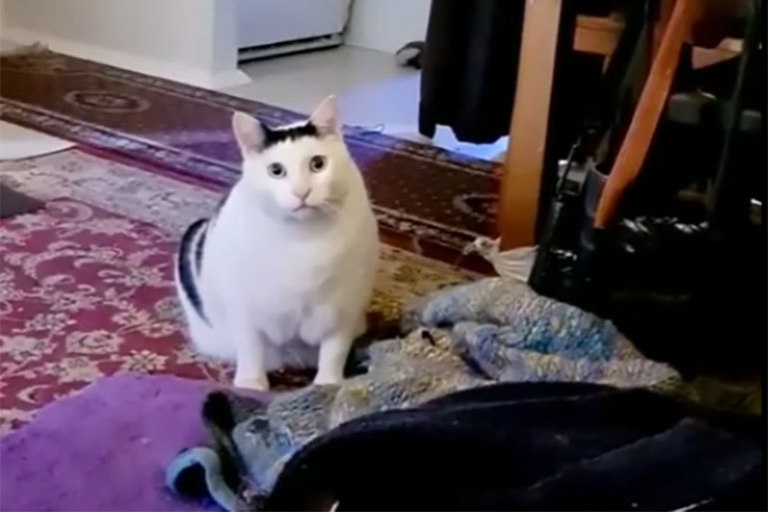

In [37]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T

image_path = "../additional_materials/images/kot_mjaukaet.jpg"
image = Image.open(image_path).convert('RGB')
image

In [59]:
transform = T.ToTensor()
image_tensor = transform(image)

In [73]:
class MedianFilter:
    def __init__(self, kernel_size=3):
        self.kernel_size = kernel_size
    def __call__(self, x):
        
        channels, height, width = x.shape
        
        # Обрамляем нулями в зависимости от размера ядра
        padding = self.kernel_size // 2
        padded_image = torch.zeros((channels, height + 2 * padding, width + 2 * padding), dtype=x.dtype)
        padded_image[:, padding:padding + height, padding:padding + width] = x
        
        filtered_x = torch.zeros_like(x)
        
        # Проходим по каждому пикселю в изображении
        for i in range(height):
            for j in range(width):
                for c in range(channels):
                    # Извлекаем соседей из окна
                    neighborhood = padded_image[c, i:i + self.kernel_size, j:j + self.kernel_size]
                    # Находим медиану среди соседей
                    median_value = neighborhood.reshape(-1).median()
                    # Присваиваем медианное значение текущему пикселю
                    filtered_x[c, i, j] = median_value
        
        return filtered_x

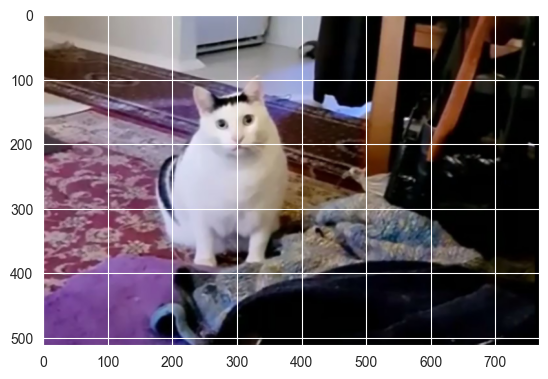

In [74]:
median_filter3 = MedianFilter(kernel_size=3)
filtered_image_3 = median_filter3(image_tensor)
plt.imshow(filtered_image_3.permute(1, 2, 0))

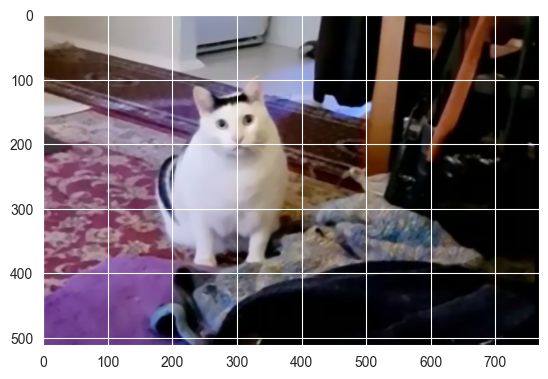

In [75]:
median_filter5 = MedianFilter(kernel_size=5)
filtered_image_5 = median_filter5(image_tensor)
plt.imshow(filtered_image_5.permute(1, 2, 0))

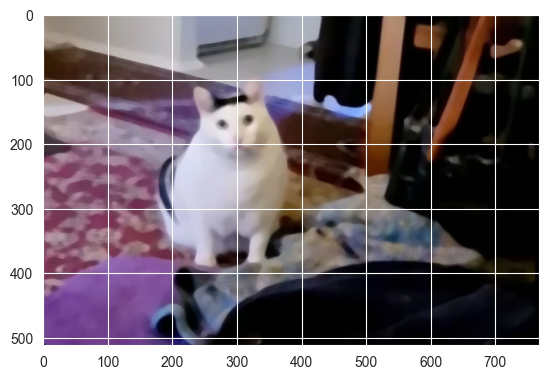

In [76]:
median_filter10 = MedianFilter(kernel_size=10)
filtered_image_10 = median_filter10(image_tensor)
plt.imshow(filtered_image_10.permute(1, 2, 0))

### Видим что все работает, фильтр "замыливает" изображение тем сильнее, чем больше размер окна.

## Задание 3

In [100]:
class BaseTransform:
    def __init__(self, p: float):
        self.p = p

    def __call__(self, image: Image.Image):
        raise NotImplementedError()

In [296]:
class RandomCrop(BaseTransform):
    def __init__(self, crop_size: int):
        super().__init__(1)
        self.crop_size = crop_size

    def __call__(self, image: Image.Image) -> Image.Image:
        width, height = image.size
        if height == self.crop_size and width == self.crop_size:
            return image
        top = torch.randint(0, height - self.crop_size, [1]).item()
        left = torch.randint(0, width - self.crop_size, [1]).item()
        bottom = top + self.crop_size
        right = left + self.crop_size
        return image.crop((left, top, right, bottom))

In [297]:
class RandomRotate(BaseTransform):
    def __init__(self, p: float, max_angle: int):
        super().__init__(p)
        self.max_angle = max_angle

    def __call__(self, image: Image.Image) -> Image.Image:
        if torch.rand(1).item() < self.p:
            angle = torch.rand(1).item() * self.max_angle
            return image.rotate(angle)
        return image

In [298]:
class RandomZoom(BaseTransform):
    def __init__(self, p: float, zoom_factor: float):
        super().__init__(p)
        self.zoom_factor = zoom_factor

    def __call__(self, image: Image.Image) -> Image.Image:
        if torch.rand(1).item() < self.p:
            width, height = image.size
            new_width = int(width * self.zoom_factor)
            new_height = int(height * self.zoom_factor)
            return image.resize((new_width, new_height))
        return image

In [306]:
class ToTensor(BaseTransform):
    def __init__(self):
        super().__init__(1)
    def __call__(self, image: Image.Image) -> torch.Tensor:
        width, height = image.size
        channels = len(image.getbands())
        image = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
        image = image.view(height, width, channels)
        image = image.permute(2, 0, 1)
        return image / 255

In [307]:
class Compose:
    def __init__(self, transforms: list[BaseTransform]):
        self.transforms = transforms

    def __call__(self, image: Image.Image):
        for transform in self.transforms:
            image = transform(image)
        return image

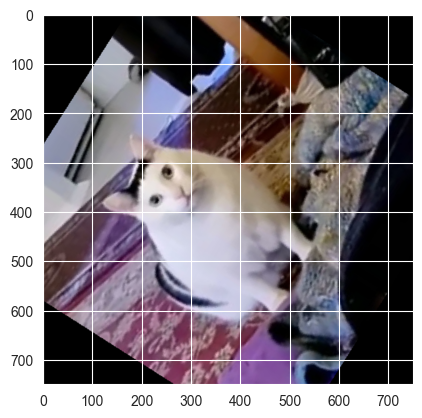

In [308]:
# Создаем цепочку трансформаций
transforms = Compose([
    RandomCrop(crop_size=500),
    RandomRotate(p=1, max_angle=90),
    RandomZoom(p=1, zoom_factor=1.5),
    ToTensor()
])

# Применяем трансформации
transformed_image = transforms(image)
plt.imshow(transformed_image.permute(1, 2, 0))

### По поводу тестирования, все работает с любыми значениями, разумеется кроме явно ошибочных таких как crop с размером больше чем сама картинка, сжатие в 0 раз и т.п.

## Задание 4 / 5

In [344]:
import wandb

lr = 1e-3
rand_rotate_p = 0.5
rand_rotate_max_angle = 45
rand_zoom_p = 0.7
rand_zoom_factor = 1.5
epochs = 10

wandb.init(
    # set the wandb project where this run will be logged
    project="Testing Transforms",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "CNN",
    "dataset": "FashionMNIST",
    "epochs": epochs,
    "random rotate p" : rand_rotate_p,
    "random rotate max angle" : rand_rotate_max_angle,
    "random zoom p" : rand_zoom_p,
    "random zoom factor" : rand_zoom_factor
    })

In [345]:
from torchvision import datasets

transforms = Compose([
    RandomZoom(p=rand_zoom_p, zoom_factor=rand_zoom_factor),
    RandomRotate(p=rand_rotate_p, max_angle=rand_rotate_max_angle),
    RandomCrop(crop_size=28),
    ToTensor()
])

train_data = datasets.FashionMNIST(
    root="../notebooks/data",
    train=True,
    transform=transforms,
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="../notebooks/data",
    train=False,
    download=True,
    transform=transforms
)

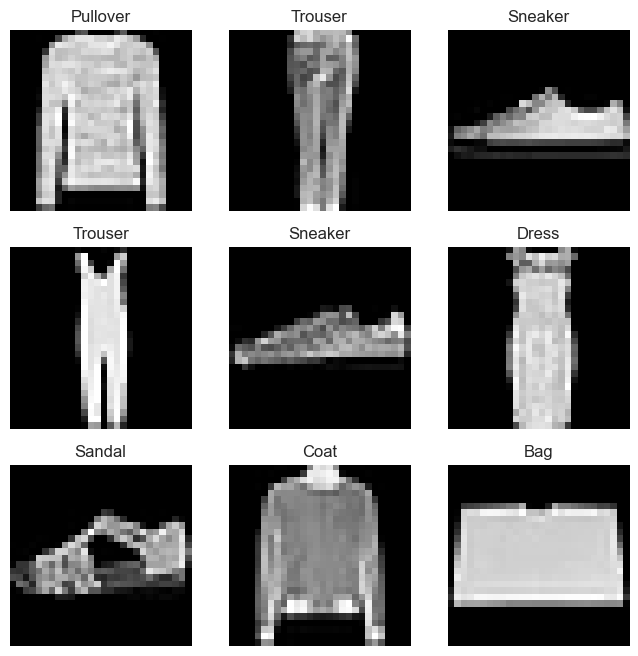

In [346]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

def plot_samples(data, labels_map, cols=3, rows=3):
    figure = plt.figure(figsize=(8, 8))
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        if type(label) == torch.Tensor:
            plt.title(labels_map[label.item()])
        else:
            plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

plot_samples(train_data, labels_map, cols=3, rows=3)

In [347]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [348]:
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataloader import default_collate

# writer = SummaryWriter(log_dir='tb/hw_2')   в итоге делаю на w&b

train_loader = DataLoader(train_data, batch_size=64, shuffle=True,
                          collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_loader = DataLoader(test_data, batch_size=64, shuffle=False,
                         collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [349]:
from torch import nn

class my_model(nn.Module):
    def __init__(self):
        super(my_model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        return x

In [350]:
from sklearn.metrics import recall_score, precision_score

def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = preds.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    accuracy = 100 * correct / total
    avg_loss = running_loss / size
    
    print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    # writer.add_scalar('Loss/train', avg_loss, epoch)
    # writer.add_scalar('Accuracy/train', accuracy, epoch)
    wandb.log({"train accuracy": accuracy, "train loss": avg_loss})


In [351]:
def test(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, num_correct = 0, 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            preds = model(inputs)
            num_correct += (preds.argmax(1) == targets).type(torch.float).sum().item()
            test_loss += loss_fn(preds, targets).item()
            
            # Store predictions and targets for metrics computation
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_loss /= num_batches
    
    # Compute precision and recall
    precision = 100 * precision_score(all_targets, all_preds, average='weighted', zero_division=np.nan)
    recall = 100 * recall_score(all_targets, all_preds, average='weighted', zero_division=np.nan)
    accuracy = 100 * num_correct / size

    print(f'Test Error, Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%\n'
          f'Precision: {precision:.2f}%, Recall: {recall:.2f}%')
    
    # writer.add_scalar('Loss/test', test_loss, epoch)
    # writer.add_scalar('Accuracy/test', accuracy, epoch)
    # writer.add_scalar('Precision/test', precision, epoch)
    # writer.add_scalar('Recall/test', recall, epoch)
    
    wandb.log({"test accuracy": accuracy, "test loss": test_loss, "test recall": recall, "test precision": precision})
    
    return test_loss

In [352]:
model = my_model().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [353]:
for t in range(epochs):
    train(train_loader, model, loss_fn, optimizer, t)
    test(test_loader, model, loss_fn, t)
    print('-------------------------------------------')
    
# writer.close()
wandb.finish()

Epoch 0, Loss: 0.0071, Accuracy: 83.49%
Test Error, Loss: 0.3566, Accuracy: 86.80%
Precision: 87.62%, Recall: 86.80%
-------------------------------------------
Epoch 1, Loss: 0.0046, Accuracy: 89.29%
Test Error, Loss: 0.3061, Accuracy: 89.22%
Precision: 89.44%, Recall: 89.22%
-------------------------------------------
Epoch 2, Loss: 0.0039, Accuracy: 90.75%
Test Error, Loss: 0.2654, Accuracy: 90.53%
Precision: 90.62%, Recall: 90.53%
-------------------------------------------
Epoch 3, Loss: 0.0034, Accuracy: 91.83%
Test Error, Loss: 0.2466, Accuracy: 91.18%
Precision: 91.15%, Recall: 91.18%
-------------------------------------------
Epoch 4, Loss: 0.0031, Accuracy: 92.73%
Test Error, Loss: 0.2487, Accuracy: 90.95%
Precision: 91.04%, Recall: 90.95%
-------------------------------------------
Epoch 5, Loss: 0.0028, Accuracy: 93.46%
Test Error, Loss: 0.2395, Accuracy: 91.61%
Precision: 91.59%, Recall: 91.61%
-------------------------------------------
Epoch 6, Loss: 0.0024, Accuracy: 9

test accuracy,▁▄▆▇▆▇▆███
test loss,█▅▃▂▂▁▂▁▁▂
test precision,▁▄▆▆▆▇▆███
test recall,▁▄▆▇▆▇▆███
train accuracy,▁▄▅▆▆▇▇▇██
train loss,█▅▄▃▃▂▂▂▁▁
test accuracy,91.99
test loss,0.25129
test precision,92.01333
test recall,91.99
train accuracy,96.03167


### В итоге мне это все надоело и я в отдельном py файле wandb_hw2.py несколько часов перебирал разные параметры. Файл приложен на гитхаб

### Ссылка на итоговый репорт после экспериментов
https://wandb.ai/unicorntowa-spbu/Testing%20Transforms/reports/Transformations-VS-loss-and-metrics--Vmlldzo5Njg2MzY4